# Knapsack Evaluator

This notebook evaluates TIG's knapsack algorithms against standard academic benchmark instances of the Quadratic Knapsack problem.

**Useful Links:**
  * [Challenge Description](https://tig.foundation/challenges/knapsack)
  * [Challenge Code](https://github.com/tig-foundation/tig-monorepo/blob/main/tig-challenges/src/knapsack.rs)

## 1. Setup Environment

### 1.1. Install Cargo

In [ ]:
import shutil
import os
if shutil.which("cargo") is None:
    print("cargo not found. Installing Rust and Cargo...")
    !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- -y
    os.environ["PATH"] += f":{os.environ['HOME']}/.cargo/bin"
else:
    print("cargo is already installed.")

### 1.2. Clone tig-SOTA-metrics

In [ ]:
cwd = os.getcwd()
if cwd.endswith("tig-SOTA-metrics"):
    os.chdir("knapsack_evaluator")
elif not cwd.endswith("knapsack_evaluator"):
    !git clone https://github.com/tig-foundation/tig-SOTA-metrics
    os.chdir("tig-SOTA-metrics/knapsack_evaluator")
else:
    print("already in the knapsack_evaluator directory.")

### 1.3. Install Python Dependencies

In [ ]:
!pip install -r requirements.txt

### 1.4. Download Datasets

Currently, this evaluation supports the following benchmark datasets:
* **Standard QKP:** well-known standard qkp instances of size 100-300 items.
* **QKP GroupII** well-known larger qkp instances of size 1000-2000 items.
* **QKP GroupIII** well-known larger qkp instances of size 5000-6000 items.
* **Large QKP** new qkp instances of size 500-10000 items.

All instances were sourced from [benchmark-instances-for-qkp](https://github.com/phil85/benchmark-instances-for-qkp). Optimal values or the best OFV sourced from: [results-for-qkp-benchmark-instances](https://github.com/phil85/results-for-qkp-benchmark-instances)

In [ ]:
datasets = ["Standard_QKP", "QKPGroupII", "QKPGroupIII", "Large_QKP"]
for ds in datasets:
    if not os.path.exists(f"data/{ds}"):
        !cd data && python3 download_{ds}.py
    else:
        print(f"{ds} dataset already downloaded.")

## 2. Perform Evaluation

### 2.1. Fetch Top Earning Algorithms

Knapsack challenge was updated to Quadratic Knapsack variant in round 44

In [1]:
import requests

API_URL = "https://mainnet-api.tig.foundation"

print("Fetching block")
block = requests.get(f"{API_URL}/get-block").json()["block"]
curr_round = block["details"]["round"]
print(f"Current Round: {curr_round}")

algorithms = {
    x['id']: x
    for x in requests.get(f"{API_URL}/get-algorithms?block_id={block['id']}").json()["algorithms"]
}

print(f"Fetching Top Earning Algorithms for Knapsack from Rounds 44 to {curr_round - 1}")
top_algos = []
for r in range(44, curr_round):
    data = requests.get(f"{API_URL}/get-round-emissions?round={r}").json()
    a_id, earnings = max(
        filter(
            lambda x: x[0].startswith("c003"),
            map(
                lambda x: (x[0], int(x[1]) / 1e18),
                data["algorithms"].items()
            )
        ),
        key=lambda x: x[1]
    )
    a_name = algorithms[a_id]['details']['name']
    print(f"Round: {r}, Algo: {a_name}, Round Earnings: {earnings:.2f} TIG")
    top_algos.append((r, a_name))

Fetching block
Current Round: 77
Fetching Top Earning Algorithms for Knapsack from Rounds 44 to 76
Round: 44, Algo: classic_quadkp, Round Earnings: 18305.89 TIG
Round: 45, Algo: classic_quadkp, Round Earnings: 18900.00 TIG
Round: 46, Algo: quadkp_improved, Round Earnings: 18003.41 TIG
Round: 47, Algo: quadkp_improved, Round Earnings: 18900.00 TIG
Round: 48, Algo: quadkp_improved, Round Earnings: 18900.00 TIG
Round: 49, Algo: knap_one, Round Earnings: 18698.51 TIG
Round: 50, Algo: knap_one, Round Earnings: 18900.00 TIG
Round: 51, Algo: quadkp_maximize, Round Earnings: 18716.85 TIG
Round: 52, Algo: relative_quad_fast, Round Earnings: 17964.83 TIG
Round: 53, Algo: relative_quad_fast, Round Earnings: 18900.00 TIG
Round: 54, Algo: new_relative_ultra, Round Earnings: 18609.86 TIG
Round: 55, Algo: new_relative_ultra, Round Earnings: 18667.96 TIG
Round: 56, Algo: relative_opt_fast, Round Earnings: 17834.53 TIG
Round: 57, Algo: relative_opt_fast, Round Earnings: 13816.75 TIG
Round: 58, Algo: re

### 2.2. (Optional) Evaluate Local Algorithm

If you want to evaluate an algorithm that has not been submitted to TIG (e.g. you are preparing Advance Submission):

1. Add your algorithm code to `src/{ALGORITHM_NAME}.rs` and `src/{ALGORITHM_NAME}.cu`
2. Uncomment, edit, and run the below cell

In [ ]:
# top_algos.append((curr_round + 4, {ALGORITHM_NAME}))

### 2.3. Run Evaluations

Evaluation results are saved to `evaluations` folder as csv files

In [ ]:
unique_algos = set(x[1] for x in top_algos)
for a in unique_algos:
    for ds in datasets:
        !bash run.sh data/{ds} {a}

## 3. Performance Analysis

#### SOTA Algorithms

The notebook currently compares TIG algorithms with a set of SOTA algorithms from the computational study "A Fast and Effective Breakpoints Heuristic Algorithm for the Quadratic Knapsack Problem" by Hochbaum et al. (2025)[[1]](https://arxiv.org/pdf/2408.12183). The following table details these algorithms:

|**Name**                                   |**Abbreviation**   |**Reference**           |
|-------------------------------------------|-------------------|------------------------|
| Breakpoints algorithm                     | QKBP              | Hochbaum et al. (2025) |
| Relative greedy heuristic                 | RG                | Julstrom (2005)        |
| Iterated hyperplane exploration approach  | IHEA              | Chen and Hao (2017)    |
| Gurobi-based approach                     | Gurobi            | www.gurobi.com         |
| Hexaly-based approach                     | Hexaly            | www.hexaly.com         |

#### Solution Quality

For each test instance in the datasets, there is a known best Objective Function Value (OFV). 

The solution found by each algorithm (TIG or SOTA) is "scored" using the Relative Percentage Deviation (RPD) from the best OFV. A lower RPD indicates a better performance, signifying a solution closer to the optimal value:

$$\text{RPD} = 100 \times \frac{\text{knapsack\_value} - \text{best OFV}}{\text{knapsack\_value}}$$

### 3.1 Load Data

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# load SOTA results
sota_results = []
for ds in datasets:
    df = pd.read_csv(f"data/{ds}/sota.csv", engine='python')
    df['instance'] = df['instance'].str.replace('.txt', '')
    df[['size', 'density','index']] = df['instance'].str.split('_', expand=True)
    df['size'] = df['size'].astype(int)
    df['dataset'] = ds
    sota_results.append(df)
sota_df = pd.concat(sota_results, ignore_index=True)

# load TIG results
tig_results = []
for ds in datasets:
    for a in unique_algos:
        df = pd.read_csv(f"evaluations/c003_{ds}_{a}.csv", engine='python')
        df['instance'] = df['instance'].str.replace('.txt', '')
        df[['size', 'density','index']] = df['instance'].str.split('_', expand=True)
        df['dataset'] = ds
        df['size'] = df['size'].astype(int)
        df['algorithm'] = a
        tig_results.append(df)
tig_df = pd.concat(tig_results, ignore_index=True)

mapping = pd.DataFrame([
    {'algorithm': algo_name, 'round': round_num} 
    for round_num, algo_name in top_algos
])

## 3.2. Comparison Plot

This plot consists of four subplots comparing of the average RPD of the top-earning TIG algorithm by round against the SOTA algorithms, QKBP, IHEA, RG, Gurobi and Hexaly, on each benchmark dataset.

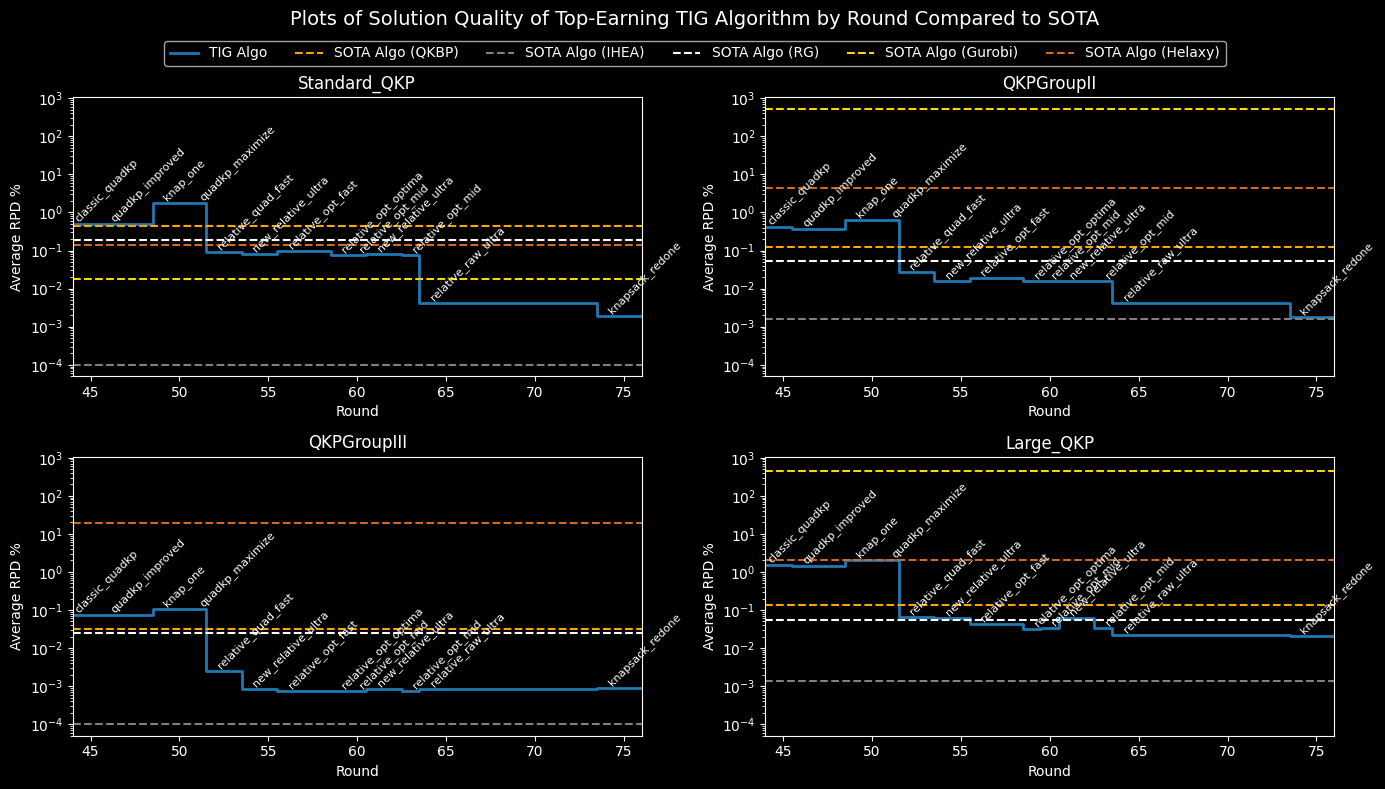

In [6]:
plot1_tig_df = (
    tig_df
        .groupby(['dataset', 'algorithm'])
        .agg(avg_gap_percent=('gap_percent', 'mean'))
        .reset_index()
        .merge(mapping, on='algorithm', how='inner')
        .sort_values(['dataset', 'round'])
)


plot1_sota_df = (
    sota_df
        .groupby(['dataset', 'algorithm'])
        .agg(avg_gap_percent=('gap', 'mean'))
        .reset_index()
)
# Define epsilon for log scale plotting
epsilon = 1e-4

# Define plot parameters - handle case where dataframes might be empty
xmin = plot1_tig_df['round'].min() 
xmax = plot1_tig_df['round'].max() 
y_min = plot1_tig_df['avg_gap_percent'].min()
y_max = plot1_tig_df['avg_gap_percent'].max()

# Add epsilon to SOTA values for log scale visibility
sota_min = (plot1_sota_df['avg_gap_percent'] + epsilon).min()
sota_max = (plot1_sota_df['avg_gap_percent'] + epsilon).max()
y_min = min(y_min, sota_min)
y_max = max(y_max, sota_max)

# Add some padding and ensure positive values for log scale
y_min = max(y_min * 0.5, 5e-7)
y_max = 2*y_max
y_limits = (y_min, y_max)


# Plot
cols, rows = 2, (len(datasets) + 1) // 2
plt.style.use('dark_background')
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)
axes = axes.flatten()

# Define colors and line styles for SOTA algorithms
sota_styles = {
    'QKBP': {'color': 'orange', 'linestyle': '--', 'label': 'SOTA Algo (QKBP)'},
    'IHEA': {'color': 'grey', 'linestyle': '--', 'label': 'SOTA Algo (IHEA)'},
    'RG': {'color': 'white', 'linestyle': '--', 'label': 'SOTA Algo (RG)'},
    'Gurobi': {'color': 'gold', 'linestyle': '--', 'label': 'SOTA Algo (Gurobi)'},
    'Hexaly': {'color': 'chocolate', 'linestyle': '--', 'label': 'SOTA Algo (Helaxy)'}
}

for i, d in enumerate(datasets):
    ax = axes[i]
    subset_df = plot1_tig_df[plot1_tig_df['dataset'] == d].sort_values('round')
    ax.step(subset_df['round'], subset_df['avg_gap_percent'], color='tab:blue',linewidth = '2', label='TIG Algo', where='mid')

    # Label algorithm changes
    for j, (_, r) in enumerate(subset_df.iterrows()):
        if j == 0 or r['algorithm'] != subset_df.iloc[j-1]['algorithm']:
            ax.text(r['round'], r['avg_gap_percent'], r['algorithm'],
                   rotation=45, va='bottom', ha='left', fontsize=8)

    # Add SOTA baselines if available
    sota_subset = plot1_sota_df[plot1_sota_df['dataset'] == d]
    for sota_algo in ['QKBP', 'IHEA', 'RG', 'Gurobi', 'Hexaly']:
        sota_data = sota_subset[sota_subset['algorithm'] == sota_algo]
        sota_gap = sota_data['avg_gap_percent'].iloc[0] + epsilon
        style = sota_styles[sota_algo]
        ax.axhline(sota_gap, linestyle=style['linestyle'], 
                  color=style['color'], label=style['label'])

    ax.set_title(d)
    ax.set_xlabel('Round')
    ax.set_ylabel('Average RPD %')
    ax.set_xlim(xmin, xmax)
    ax.set_yscale('log')
    ax.set_ylim(y_limits)

# Remove unused axes
for j in range(len(datasets), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Plots of Solution Quality of Top-Earning TIG Algorithm by Round Compared to SOTA', fontsize=14)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 0.95), fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### How to Interpret This Plot

The above step plots show which TIG algorithm was the top-earning algorithm for a given round. If the same algorithm remains the top-earning algorithm for continuous rounds, it appears as a long, flat segment on the plot.

Dashed lines represent the performance of SOTA algorithms. Unlike TIG algorithms, their performance is fixed and does not vary across rounds, so they appear as straight horizontal lines. 

In this plot, lower lines indicate better performance.

#### Key Algorithms to Note:
- IHEA: A highly effective algorithm that consistently finds near-optimal solutions. However, this accuracy comes at a significant cost — it runs approximately 100× slower than QKBP (2025).
- QKBP (2025): A recently published, peer-reviewed algorithm that produces high-quality solutions in significantly faster runtimes than previous SOTA methods.

The current top-performing TIG algorithm outperforms QKBP in solution quality while maintaining a similarly fast runtime. This makes it the most direct and fair "apples-to-apples" comparison against a leading SOTA algorithm.